<h2><center>Long-term Visits Prediction of 140K Web Pages</center></h2>
<font color=blue><h3><center>======= Part 3. Seq2seq Architecture with LSTM ========</center></h3></font>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import boto3, os
import io
from boto.s3.key import Key

ACCESS_KEY="a_key"
SECRET_KEY="s_key"

bucket='capstone0project2'
file_key = 'train_2.csv'

client = boto3.client(
    's3',
    aws_access_key_id=ACCESS_KEY,
    aws_secret_access_key=SECRET_KEY)
# Get data from the AWS S3 bucket
response = client.get_object(Bucket=bucket, Key=file_key)
df = pd.read_csv(io.BytesIO(response['Body'].read()))

In [3]:
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0,7.0


In [4]:
data_start_date = df.columns[1]
data_end_date = df.columns[-1]
print('Data ranges from %s to %s' % (data_start_date, data_end_date))

Data ranges from 2015-07-01 to 2017-09-10


In [5]:
from datetime import timedelta

pred_steps = 62
pred_length=timedelta(pred_steps)

first_day = pd.to_datetime("2016-07-10")
last_day = pd.to_datetime(data_end_date)

val_pred_start = last_day - pred_length + timedelta(1)
val_pred_end = last_day

train_pred_start = val_pred_start - pred_length
train_pred_end = val_pred_start - timedelta(days=1)

In [6]:
enc_length = train_pred_start - first_day

train_enc_start = first_day
train_enc_end = train_enc_start + enc_length - timedelta(1)

val_enc_start = train_enc_start + pred_length
val_enc_end = val_enc_start + enc_length - timedelta(1)

In [7]:
print('Train encoding:', train_enc_start, '-', train_enc_end)
print('Train prediction:', train_pred_start, '-', train_pred_end, '\n')
print('Val encoding:', val_enc_start, '-', val_enc_end)
print('Val prediction:', val_pred_start, '-', val_pred_end)

print('\nEncoding interval:', enc_length.days)
print('Prediction interval:', pred_length.days)

Train encoding: 2016-07-10 00:00:00 - 2017-05-09 00:00:00
Train prediction: 2017-05-10 00:00:00 - 2017-07-10 00:00:00 

Val encoding: 2016-09-10 00:00:00 - 2017-07-10 00:00:00
Val prediction: 2017-07-11 00:00:00 - 2017-09-10 00:00:00

Encoding interval: 304
Prediction interval: 62


In [8]:
# fill the NaN values with 0 since the dataset does not distinguish between 0 and missing
df=df.fillna(0)

series_array = df[df.columns[1:]].values # (145063, 803)

index_series = pd.Series(index=pd.Index([pd.to_datetime(i) for i in df.columns[1:]]),
                          data=[j for j in range(len(df.columns[1:]))]) # (803,)

In [9]:
def get_time_block_series(series_array, index_series, start_date, end_date):
    ''' Return 145063 * (#day intervals) '''
    idxs = index_series[start_date:end_date]
    return series_array[:,idxs]

def transform_series_encode(series_array):
    ''' Standardize blocks of TS and transfer to Keras format '''
    series_array = np.log1p(series_array) # log transform for computation
    series_mean = series_array.mean(axis=1).reshape(-1,1) 
    series_array = series_array - series_mean # standardize
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    
    series_array = np.log1p(series_array) 
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array

In [10]:
from keras.models import Model # Import Keras Model API
from keras.layers import Input, Dense, LSTM
from keras.optimizers import Adam
from keras import backend as K

K.set_learning_phase(1) #set learning phase

latent_dim = 50 # hidden units
dropout = .20 

# Define an input series and encode it with an LSTM. 
encoder_inputs = Input(shape=(None, 1)) 
#encoder = GRU(latent_dim, dropout=dropout, return_state=True)
encoder = LSTM(latent_dim, dropout=dropout, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the final states. These represent the "context"
# vector that we use as the basis for decoding.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
# This is where teacher forcing inputs are fed in.
decoder_inputs = Input(shape=(None, 1)) 

# We set up our decoder using `encoder_states` as initial state.  
# We return full output sequences and return internal states as well. 
# We don't use the return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, dropout=dropout, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)

decoder_dense = Dense(1) # 1 continuous output at each timestep
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

Using TensorFlow backend.


In [11]:
first_n_samples = 100000
batch_size = 2**11
epochs = 100

# sample of series from train_enc_start to train_enc_end  
encoder_input_data = get_time_block_series(series_array, index_series, 
                                           train_enc_start, train_enc_end)[:first_n_samples]
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)
# (145063, 679, 1)


# sample of series from train_pred_start to train_pred_end 
decoder_target_data = get_time_block_series(series_array, index_series, 
                                            train_pred_start, train_pred_end)[:first_n_samples]
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)
# (145063, 62, 1)

# lagged target series for teacher forcing
decoder_input_data = np.zeros(decoder_target_data.shape)
decoder_input_data[:,1:,0] = decoder_target_data[:,:-1,0] 
decoder_input_data[:,0,0] = encoder_input_data[:,-1,0] 

model.compile(Adam(), loss='mean_absolute_error')
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                     batch_size=batch_size,
                     epochs=epochs,
                     validation_split=0.2)

Train on 80000 samples, validate on 20000 samples
Epoch 1/100
80000/80000 [==============================] - 37s - loss: 0.3949 - val_loss: 0.3157
Epoch 2/100
80000/80000 [==============================] - 36s - loss: 0.3322 - val_loss: 0.3034
Epoch 3/100
80000/80000 [==============================] - 36s - loss: 0.3230 - val_loss: 0.2959
Epoch 4/100
80000/80000 [==============================] - 36s - loss: 0.3135 - val_loss: 0.2813
Epoch 5/100
80000/80000 [==============================] - 36s - loss: 0.2962 - val_loss: 0.2646
Epoch 6/100
80000/80000 [==============================] - 36s - loss: 0.2861 - val_loss: 0.2584
Epoch 7/100
80000/80000 [==============================] - 36s - loss: 0.2823 - val_loss: 0.2570
Epoch 8/100
80000/80000 [==============================] - 36s - loss: 0.2791 - val_loss: 0.2535
Epoch 9/100
80000/80000 [==============================] - 36s - loss: 0.2768 - val_loss: 0.2490
Epoch 10/100
80000/80000 [==============================] - 36s - loss: 0.274

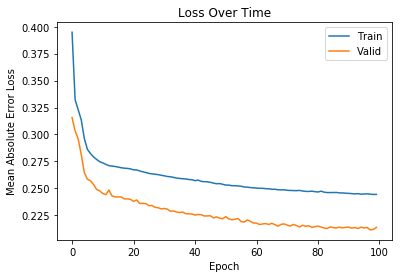

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [13]:
from keras.models import model_from_json

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [14]:
# from keras.models import model_from_json

# #load json and create model
# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("model.h5")
# print("Loaded model from disk")

In [15]:
# from our previous model - mapping encoder sequence to state vectors
encoder_model = Model(encoder_inputs, encoder_states)

# A modified version of the decoding stage that takes in predicted target inputs
# and encoded state vectors, returning predicted target outputs and decoder state vectors.
# We need to hang onto these state vectors to run the next step of the inference loop.
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs,
                      [decoder_outputs] + decoder_states)

def decode_sequence(input_seq):
    
    # Encode the input as state vectors.
    K.set_learning_phase(0) 
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, 1))
    
    # Populate the first target sequence with end of encoding series pageviews
    target_seq[0, 0, 0] = input_seq[0, -1, 0]

    # Sampling loop for a batch of sequences - we will fill decoded_seq with predictions
    # (to simplify, here we assume a batch of size 1).

    decoded_seq = np.zeros((1,pred_steps,1))
    
    for i in range(pred_steps):
        
        output, h, c = decoder_model.predict([target_seq] + states_value)
        
        decoded_seq[0,i,0] = output[0,0,0]

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, 1))
        target_seq[0, 0, 0] = output[0,0,0]

        # Update states
        states_value = [h, c]

    return decoded_seq

In [19]:
encoder_input_data = get_time_block_series(series_array, index_series, val_enc_start, val_enc_end)
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)
# (145063, 679, 1), (145063, 1)

# (145063, 62)
decoder_target_data = get_time_block_series(series_array, index_series, val_pred_start, val_pred_end)
#decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

In [20]:
def smape(true, pred):
    summ = np.abs(true+pred)
    diff = np.abs(true-pred)
    df_smape = np.where(summ == 0, 0, diff / summ)
    smape = 200*df_smape.sum()/true.shape[0]
    return smape 

In [21]:
import datetime

smape_s=0
for i in range(0,df.shape[0]):
    # Get the transformed series
    encode_series = encoder_input_data[i:i+1,:,:] 
    
    # Predict the target value with trained model
    pred_series = decode_sequence(encode_series)    
    pred_series = pred_series.reshape(-1,1) 
    
    # Back transform the prediction with mean and inverse of the np.log1p
    pred_series=pred_series+encode_series_mean[i]
    pred_series=np.expm1(pred_series)
    
    # Get the target series from the original data without transformation
    target_series = decoder_target_data[i].reshape(-1,1) 
    
    smape_i=smape(target_series,pred_series)
    smape_s=smape_s+smape_i
    if i%1000==0 or i in (5,10,50,100):
        print(i,smape_s)
        print(datetime.datetime.now())

print(smape_s/df.shape[0])

0 35.3279282094
2018-10-30 04:03:49.334176
5 270.309528621
2018-10-30 04:03:50.443010
10 483.836738168
2018-10-30 04:03:51.517785
50 2202.87401879
2018-10-30 04:04:00.059876
100 5195.8446171
2018-10-30 04:04:10.886060
1000 43920.3434042
2018-10-30 04:07:22.139992
2000 85680.1166171
2018-10-30 04:10:54.416049
3000 127591.193095
2018-10-30 04:14:25.939672
4000 173299.698354
2018-10-30 04:17:57.337952
5000 220814.765568
2018-10-30 04:21:29.212264
6000 263037.408887
2018-10-30 04:25:00.145355
7000 305429.164354
2018-10-30 04:28:32.151140
8000 349574.688466
2018-10-30 04:32:05.336849
9000 392266.752775
2018-10-30 04:35:37.044157
10000 426203.030183
2018-10-30 04:39:08.588075
11000 464212.025994
2018-10-30 04:42:40.170109
12000 499387.029538
2018-10-30 04:46:10.680814
13000 535873.164284
2018-10-30 04:49:42.054744
14000 611141.369017
2018-10-30 04:53:12.608280
15000 723730.750036
2018-10-30 04:56:43.168548
16000 827866.115169
2018-10-30 05:00:15.110311
17000 866582.643527
2018-10-30 05:03:45

In [22]:
encoder_input_data = get_time_block_series(series_array, index_series, val_enc_start, val_enc_end)
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)
# (145063, 679, 1), (145063, 1)

# (145063, 62)
decoder_target_data = get_time_block_series(series_array, index_series, val_pred_start, val_pred_end)
decoder_target_data = transform_series_decode(decoder_target_data,encode_series_mean)
def predict_and_plot(encoder_input_data, decoder_target_data, sample_ind, enc_tail_len=50):

    encode_series = encoder_input_data[sample_ind:sample_ind+1,:,:] 
    pred_series = decode_sequence(encode_series)
    
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data[sample_ind,:,:1].reshape(-1,1) 
    
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    
    plt.figure(figsize=(10,6))   
    
    plt.plot(range(1,x_encode+1),encode_series_tail)
    plt.plot(range(x_encode,x_encode+pred_steps),target_series,color='orange')
    plt.plot(range(x_encode,x_encode+pred_steps),pred_series,color='teal',linestyle='--')
    
    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])

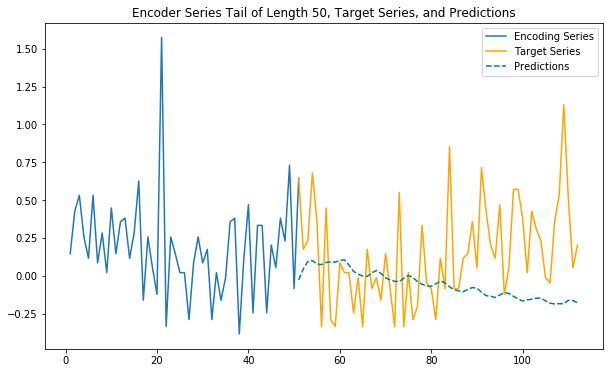

In [23]:
predict_and_plot(encoder_input_data, decoder_target_data, 227)

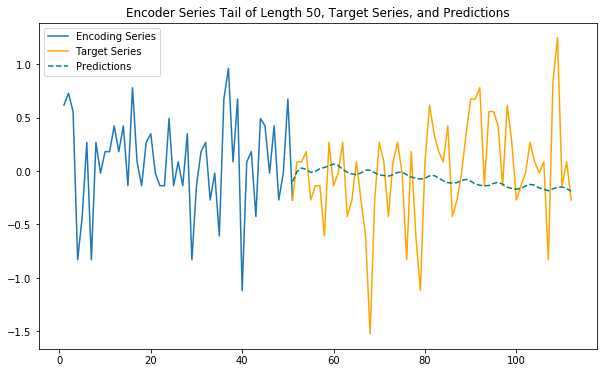

In [24]:
predict_and_plot(encoder_input_data, decoder_target_data, 3374)

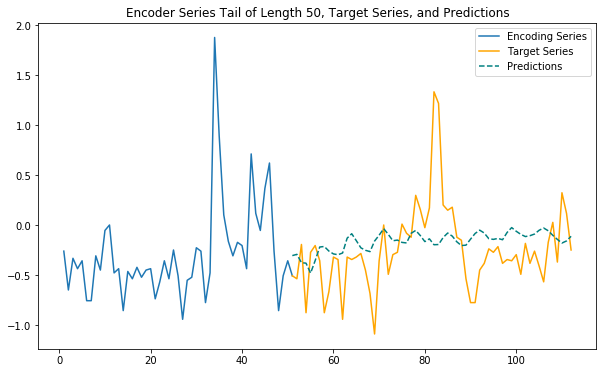

In [25]:
predict_and_plot(encoder_input_data, decoder_target_data, 8135)

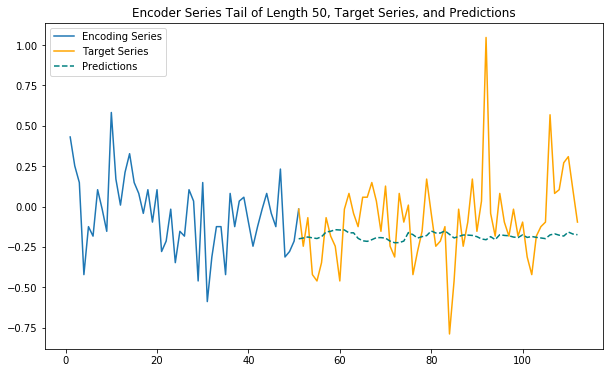

In [26]:
predict_and_plot(encoder_input_data, decoder_target_data, 109901)

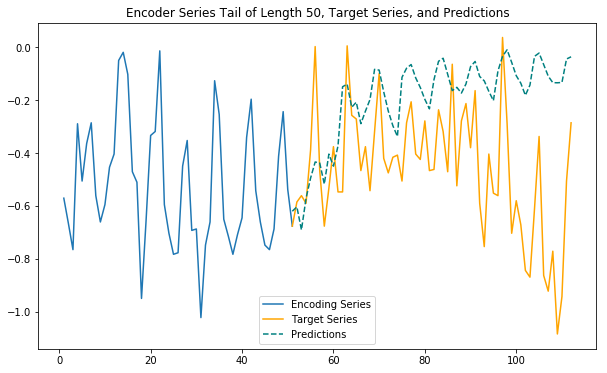

In [29]:
predict_and_plot(encoder_input_data, decoder_target_data, 51523)

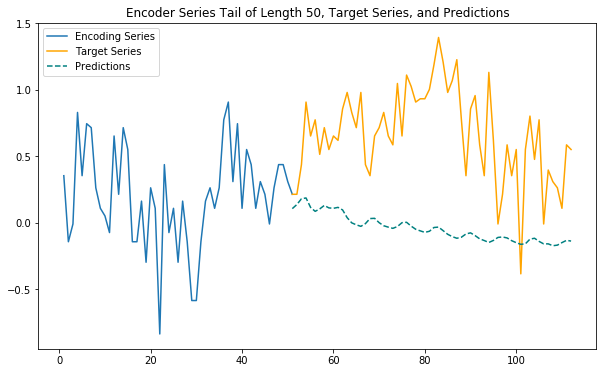

In [30]:
predict_and_plot(encoder_input_data, decoder_target_data, 51996)

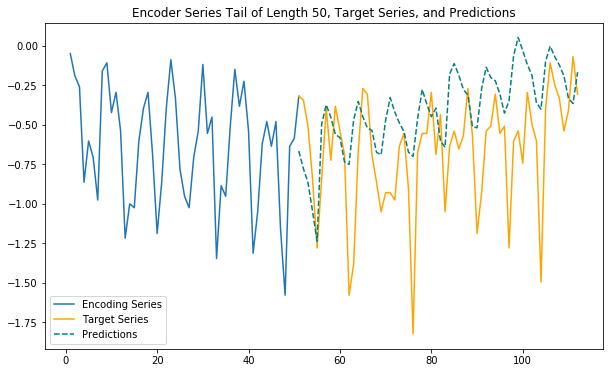

In [31]:
predict_and_plot(encoder_input_data, decoder_target_data, 65000)

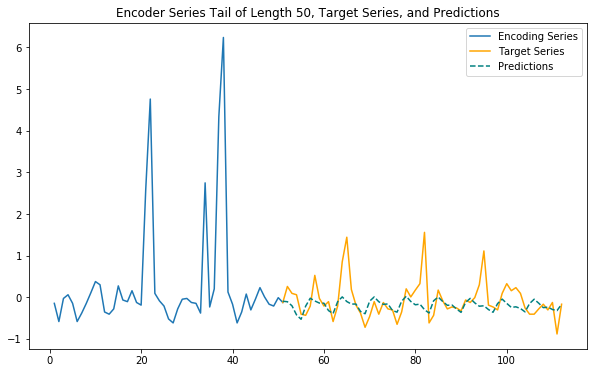

In [32]:
predict_and_plot(encoder_input_data, decoder_target_data, 80806)

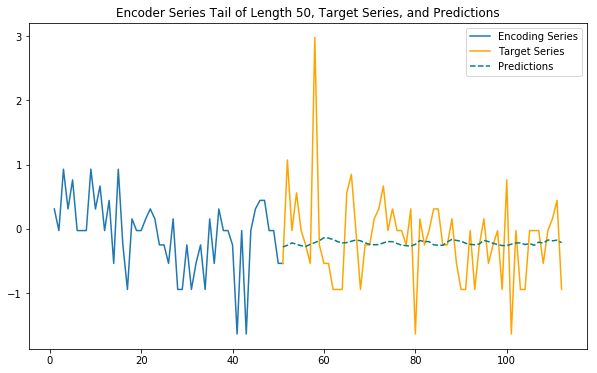

In [34]:
predict_and_plot(encoder_input_data, decoder_target_data, 109907)

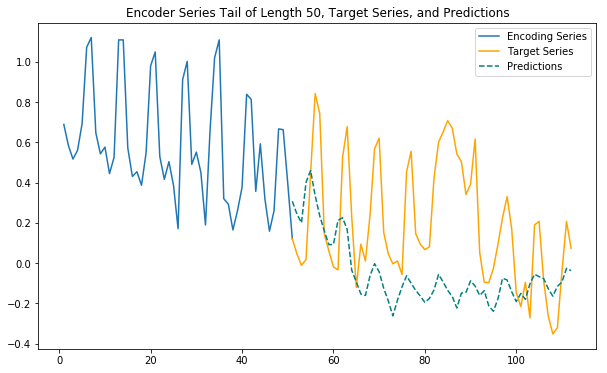

In [35]:
predict_and_plot(encoder_input_data, decoder_target_data, 120719)

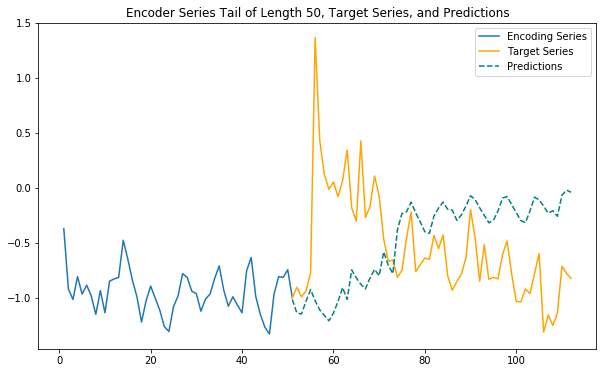

In [36]:
predict_and_plot(encoder_input_data, decoder_target_data, 137601)

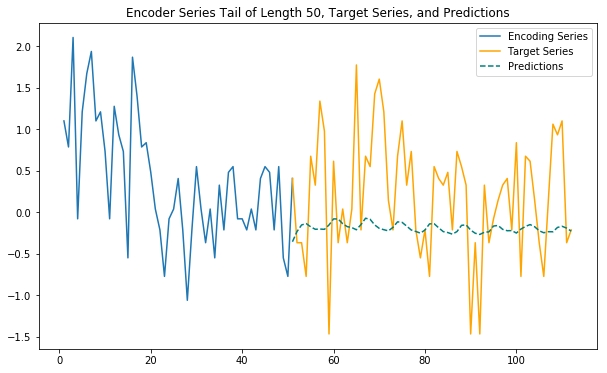

In [37]:
predict_and_plot(encoder_input_data, decoder_target_data, 141594)